In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

df = pd.read_parquet("data/bergingspercentage_rucphen_parquet/RUC0011_WTH_RIO.Bergingspercentage.parquet")
df_metadata = pd.read_parquet("data/bergingspercentage_rucphen_parquet/RUC0011_WTH_RIO.Bergingspercentage.metadata.parquet")

In [131]:
# Data cleaning/preperation
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d-%m-%Y %H:%M:%S")
df.drop(columns= 'Date', inplace= True)

# Rename columns
df = df.rename(columns={'Value [m³/h]': 'percentage'})
# Define the desired order of columns
desired_order = ['timestamp', 'percentage']

# Reorder columns using reorder_levels
df = df[desired_order]
df.head()

,timestamp,percentage
0,2018-01-01 00:00:00,100.0
1,2018-01-01 00:05:00,100.0
2,2018-01-01 00:10:00,100.0
3,2018-01-01 00:15:00,100.0
4,2018-01-01 00:20:00,100.0


In [132]:
df_weather = pd.read_parquet("try_map/polygon_1663.parquet")
df_weather.sort_values(by=['timestamp'], inplace=True)
df_weather.reset_index(drop=True, inplace=True)
df_weather.head()

,timestamp,precipitation
0,2019-01-01 00:00:00,0.0
1,2019-01-01 00:05:00,0.0
2,2019-01-01 00:10:00,0.0
3,2019-01-01 00:15:00,0.0
4,2019-01-01 00:20:00,0.0


Min Timestamp: 2019-01-01 00:00:00, Max Timestamp: 2023-12-11 08:50:00
Gaps found. Time ranges with missing rows that have gaps of longer than 10 minutes:
Row 10997: 2019-02-08 23:00:00 - 2019-02-09 01:10:00
Row 11001: 2019-02-09 01:25:00 - 2019-02-09 02:30:00
Row 34144: 2019-04-30 18:00:00 - 2019-04-30 19:15:00
Row 41962: 2019-05-27 22:50:00 - 2019-05-28 05:20:00
Row 54095: 2019-07-09 08:25:00 - 2019-07-09 09:40:00
Row 77959: 2019-09-30 07:55:00 - 2019-10-01 01:30:00
Row 78037: 2019-10-01 07:55:00 - 2019-10-01 19:50:00
Row 78183: 2019-10-02 07:55:00 - 2019-10-02 19:50:00
Row 83510: 2019-10-21 07:55:00 - 2019-10-22 08:00:00
Row 102571: 2019-12-27 13:40:00 - 2019-12-27 14:55:00
Row 145840: 2020-05-25 21:10:00 - 2020-05-26 07:40:00
Row 156594: 2020-07-02 15:45:00 - 2020-07-02 17:15:00
Row 186123: 2020-10-13 07:55:00 - 2020-10-14 08:00:00
Row 204841: 2020-12-18 07:55:00 - 2020-12-19 00:00:00
Row 205129: 2020-12-19 23:55:00 - 2020-12-20 08:00:00
Row 205417: 2020-12-21 07:55:00 - 2020-12-22

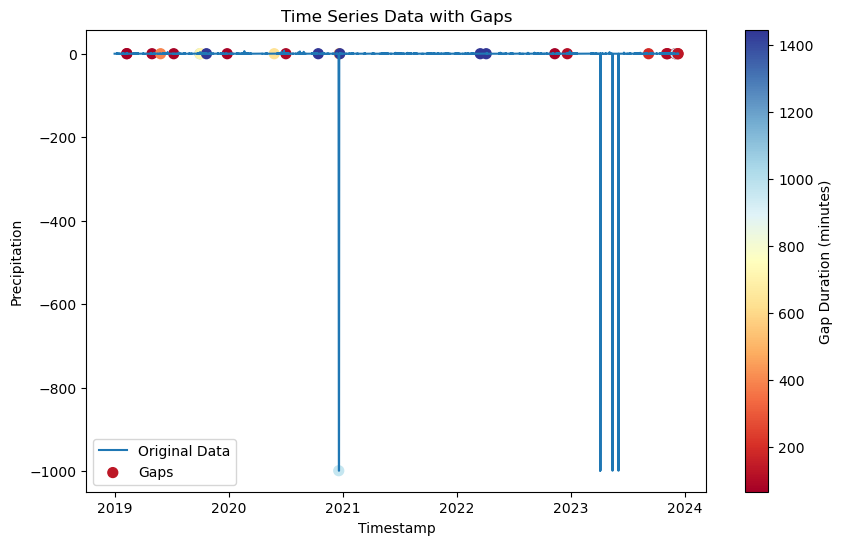

In [133]:
import pandas as pd

def check_empty_rows(df: pd.DataFrame):
    """
    Checks if there are any missing rows in a DataFrame with a timestamp column.
    :param df: The DataFrame to check
    :param timestamp_column: The name of the timestamp column
    :param expected_time_diff: The expected time difference between consecutive rows
    :return: A list of tuples with the start and end of the missing rows
    """
    # Assuming your DataFrame is named 'df' and the timestamp column is named 'timestamp'
    # Make sure the timestamp column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Step 1: Check the time range
    min_timestamp = df['timestamp'].min()
    max_timestamp = df['timestamp'].max()
    print(f"Min Timestamp: {min_timestamp}, Max Timestamp: {max_timestamp}")

    # Step 2: Check the time difference between consecutive rows
    time_diff = df['timestamp'].diff().dropna()
    expected_time_diff = pd.Timedelta(minutes=5)

    # Identify gaps excluding cases where the time difference is zero
    # (time_diff != pd.Timedelta(0)) & 
    gaps = time_diff[(time_diff != expected_time_diff) & (time_diff > pd.Timedelta(minutes=60))]

    # Check if there are any gaps
    if not gaps.empty:
        print("Gaps found. Time ranges with missing rows that have gaps of longer than 10 minutes:")
        for idx in gaps.index:
            print(f"Row {idx}: {df['timestamp'].iloc[idx - 1]} - {df['timestamp'].iloc[idx]}")
    else:
        print("No gaps found. The DataFrame has a row for every five minutes.")
        

    # Calculate gap durations
    gap_durations = gaps.dt.total_seconds()/60

    # Create a colormap (blues for shorter durations, reds for longer durations)
    colormap = plt.cm.RdYlBu
    norm = Normalize(vmin=gap_durations.min(), vmax=gap_durations.max())
    colors = [colormap(norm(duration)) for duration in gap_durations]

    # Plot the time series with colored markers for gap durations
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_weather['timestamp'], df_weather['precipitation'], label='Original Data')
    scatter = ax.scatter(df_weather['timestamp'][gaps.index], df_weather['precipitation'][gaps.index],
                        color=colors, label='Gaps', s=50)

    # Create a colorbar to show the mapping of gap durations to colors
    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Gap Duration (minutes)')

    ax.set_title('Time Series Data with Gaps')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Precipitation')
    ax.legend()
    plt.show()

check_empty_rows(df_weather)
df_weather_without_negative = df_weather.copy()
df_weather_without_negative['precipitation'] = df_weather['precipitation'].apply(lambda x: x if x >= 0 else 0)



# Example of a gap of five minutes

In [134]:
df_02_01_2019 = pd.read_parquet("./data/neerslag_ai/year=2019/month=1/day=2/part-00001-066c401c-a6ee-4a09-946d-98cb8d7a4367.c000.snappy.parquet")

df_02_01_2019.sort_values(by=['timestamp'], inplace=True)
df_02_01_2019

,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source
220,2019-01-02 00:00:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
221,2019-01-02 00:05:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
222,2019-01-02 00:10:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
223,2019-01-02 00:15:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
224,2019-01-02 00:20:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2019-01-02 23:35:00,0.07,0.07,0.07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
280,2019-01-02 23:40:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
281,2019-01-02 23:45:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
282,2019-01-02 23:50:00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis


In [135]:
df_02_01_2019[(df_02_01_2019['timestamp'] >= '2019-01-02 04:15:00 ') & (df_02_01_2019['timestamp'] <= '2019-01-02 04:35:00')]

,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source
208,2019-01-02 04:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
209,2019-01-02 04:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
210,2019-01-02 04:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
211,2019-01-02 04:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis


Turns out it is an issue in the source data

# Example of a missing day

In [136]:
df_16_04_2023_1 = pd.read_parquet("./data/neerslag_ai/year=2023/month=4/day=16/part-00009-ea8a2234-e020-4c04-8573-85be1f964f73.c000.snappy.parquet")
df_16_04_2023_2 = pd.read_parquet("./data/neerslag_ai/year=2023/month=4/day=16/part-00009-5d097a83-e8c9-4eeb-ab45-91fb44e022c0.c000.snappy.parquet")
df_16_04_2023_3 = pd.read_parquet("./data/neerslag_ai/year=2023/month=4/day=16/part-00009-09ab9085-a1b6-48d9-9d0f-6db4e3c920c5.c000.snappy.parquet")
# Concatenate the DataFrames
df_16_04_2023 = pd.concat([df_16_04_2023_1, df_16_04_2023_2, df_16_04_2023_3], ignore_index=True)

# Print information about the merged DataFrame
print("Shape of the merged DataFrame:", df_16_04_2023.shape)
print("Columns of the merged DataFrame:", df_16_04_2023.columns)

df_16_04_2023.sort_values(by=['timestamp'], inplace=True)
df_16_04_2023.head()

Shape of the merged DataFrame: (408, 3552)
Columns of the merged DataFrame: Index(['timestamp', 'polygon_0', 'polygon_1', 'polygon_2', 'polygon_3',
       'polygon_4', 'polygon_5', 'polygon_6', 'polygon_7', 'polygon_8',
       ...
       'polygon_3541', 'polygon_3542', 'polygon_3543', 'polygon_3544',
       'polygon_3545', 'polygon_3546', 'polygon_3547', 'polygon_3548',
       'polygon_3549', 'data_source'],
      dtype='object', length=3552)


,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source
407,2023-04-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
95,2023-04-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
406,2023-04-16 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
94,2023-04-16 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
93,2023-04-16 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis


In [137]:
df_16_04_2023[(df_16_04_2023['timestamp'] >= '2023-04-16 08:00:00') & (df_16_04_2023['timestamp'] <= '2023-04-16 23:55:00')]

,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source
311,2023-04-16 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
310,2023-04-16 08:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
309,2023-04-16 08:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
308,2023-04-16 08:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
307,2023-04-16 08:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-04-16 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,realtime
97,2023-04-16 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,realtime
121,2023-04-16 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis
120,2023-04-16 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,early_reanalysis


In [138]:
df_weather[(df_weather['timestamp'] >= '2023-04-16 08:00:00') & (df_weather['timestamp'] <= '2023-04-16 23:55:00')]

,timestamp,precipitation
489118,2023-04-16 08:00:00,0.0
489119,2023-04-16 08:05:00,0.0
489120,2023-04-16 08:10:00,0.0
489121,2023-04-16 08:15:00,0.0
489122,2023-04-16 08:20:00,0.0
...,...,...
489329,2023-04-16 23:45:00,0.0
489330,2023-04-16 23:50:00,0.0
489331,2023-04-16 23:50:00,0.0
489332,2023-04-16 23:55:00,0.0


# Missing part of a day

In [144]:
df_13_10_2020 = pd.read_parquet("./data/neerslag_ai/year=2020/month=10/day=13/part-00000-77657a26-5a8f-4dea-b8f0-4b79f79b5a5e.c000.snappy.parquet")

In [146]:
df_13_10_2020.head()

,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source
0,2020-10-13 02:40:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
1,2020-10-13 02:45:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
2,2020-10-13 02:50:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
3,2020-10-13 02:55:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
4,2020-10-13 03:00:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-10-13 07:35:00,0.01001,0.01001,0.01001,0.01001,0.01001,0.01001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
92,2020-10-13 07:40:00,0.00000,0.01001,0.01001,0.01001,0.01001,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
93,2020-10-13 07:45:00,0.00000,0.00000,0.01001,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis
94,2020-10-13 07:50:00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,final_reanalysis


Also seems to be an issue with the source

In [145]:
# Row 186123: 2020-10-13 07:55:00 - 2020-10-14 08:00:00
df_13_10_2020[(df_13_10_2020['timestamp'] >= '2020-10-13 08:00:00') & (df_13_10_2020['timestamp'] <= '2020-10-13 23:55:00')]

,timestamp,polygon_0,polygon_1,polygon_2,polygon_3,polygon_4,polygon_5,polygon_6,polygon_7,polygon_8,...,polygon_3541,polygon_3542,polygon_3543,polygon_3544,polygon_3545,polygon_3546,polygon_3547,polygon_3548,polygon_3549,data_source


In [139]:
merged_df = pd.merge(df_weather, df, on='timestamp', how='left')
# Fill 0 when a value is under 0 0 from the 'Column_Name' column
# merged_df['precipitation'] = merged_df['precipitation'].apply(lambda x: x if x >= 0 else 0)
# merged_df.to_parquet("data/rucphen_precipitation.parquet")
merged_df.head(10)

,timestamp,precipitation,percentage
0,2019-01-01 00:00:00,0.0,7.895
1,2019-01-01 00:05:00,0.0,7.895
2,2019-01-01 00:10:00,0.0,7.895
3,2019-01-01 00:15:00,0.0,7.895
4,2019-01-01 00:20:00,0.0,7.895
5,2019-01-01 00:25:00,0.0,7.895
6,2019-01-01 00:30:00,0.0,7.895
7,2019-01-01 00:35:00,0.0,7.895
8,2019-01-01 00:40:00,0.0,7.895
9,2019-01-01 00:45:00,0.0,7.895
